In [7]:
import numpy as np
import torch
from fastai.torch_core import show_image
# A gaussian kernel cache, so we don't have to regenerate them every time.
# This is only a small optimization, generating the kernels is pretty fast.
_gaussians = {}

def generate_gaussian(t, x, y, sigma=10):
    """
    Generates a 2D Gaussian point at location x,y in tensor t.

    x should be in range (-1, 1) to match the output of fastai's PointScaler.

    sigma is the standard deviation of the generated 2D Gaussian.
    """
    h,w = t.shape

    # Heatmap pixel per output pixel
    mu_x = int(0.5 * (x + 1.) * w)
    mu_y = int(0.5 * (y + 1.) * h)

    tmp_size = sigma * 3

    # Top-left
    x1,y1 = int(mu_x - tmp_size), int(mu_y - tmp_size)

    # Bottom right
    x2, y2 = int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)
    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        return t

    size = 2 * tmp_size + 1
    tx = np.arange(0, size, 1, np.float32)
    ty = tx[:, np.newaxis]
    x0 = y0 = size // 2

    # The gaussian is not normalized, we want the center value to equal 1
    g = _gaussians[sigma] if sigma in _gaussians \
                else torch.Tensor(np.exp(- ((tx - x0) ** 2 + (ty - y0) ** 2) / (2 * sigma ** 2)))
    _gaussians[sigma] = g

    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1

    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)

    t[img_y_min:img_y_max, img_x_min:img_x_max] = \
      g[g_y_min:g_y_max, g_x_min:g_x_max]

    return t


In [8]:
from datasets import KeyPointDataset
from pathlib import Path
import torchvision.transforms as T

In [9]:
keypoint_dataset = KeyPointDataset(root=Path('/home/suyash/Gatech/DDRL/modules/data/aflw_dataset/AFLW_lists/front.GTB'), mode="train")

In [10]:
first_image = keypoint_dataset.__getitem__(0)

In [11]:
first_image['image'].size()

torch.Size([3, 256, 256])

In [6]:
first_image["final_keypoints"]

[(90.57792, 201.006265060241),
 (92.07808, 188.2987951807229),
 (96.5632, 178.66795180722892),
 (100.92032, 158.79710843373493),
 (102.27712, 143.6375903614458),
 (105.13408, 129.9122891566265),
 (94.93504, 201.006265060241),
 (98.06336, 190.3498795180723),
 (100.92032, 177.85060240963855),
 (106.76736, 157.77156626506027),
 (107.58656, 146.7142168674699),
 (109.08160000000001, 137.0833734939759),
 (120.50944, 191.16722891566266),
 (123.3664, 180.1021686746988),
 (127.85152000000001, 171.9132530120482),
 (131.6608, 207.15180722891566),
 (137.92256, 190.55807228915663),
 (139.41760000000002, 174.16481927710845),
 (151.04, 198.93975903614458)]

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [256, 256]
plt.rcParams["figure.autolayout"] = True


x = [x[0] for x in first_image["final_keypoints"]]
y = [x[1] for x in first_image["final_keypoints"]]

plt.plot(x, y, 'r*')

for xy in zip(x, y):
   plt.annotate('(%.2f, %.2f)' % xy, xy=xy)

plt.show()

In [46]:
def get_shifted_keypoints(first_image):
    coords = first_image["final_keypoints"]
    shift_amount_0 = first_image['image'].size()[1]
    shift_amount_1 = first_image['image'].size()[2]
    return [((x[0] - shift_amount_0/2)/shift_amount_0, (x[1] - shift_amount_1/2)/shift_amount_1) for x in coords]

In [47]:
shifted_keypoints = get_shifted_keypoints(first_image)

In [48]:
shifted_keypoints

[(-0.14617999999999998, 0.2851807228915664),
 (-0.14032, 0.2355421686746988),
 (-0.12280000000000002, 0.19792168674698796),
 (-0.10577999999999999, 0.12030120481927709),
 (-0.10048000000000001, 0.061084337349397666),
 (-0.08932000000000001, 0.00746987951807232),
 (-0.12916, 0.2851807228915664),
 (-0.11693999999999999, 0.24355421686746992),
 (-0.10577999999999999, 0.1947289156626506),
 (-0.08294000000000001, 0.11629518072289169),
 (-0.07973999999999998, 0.0731024096385543),
 (-0.07389999999999997, 0.03548192771084335),
 (-0.029260000000000008, 0.24674698795180727),
 (-0.018100000000000005, 0.20352409638554214),
 (-0.0005799999999999694, 0.17153614457831323),
 (0.01429999999999998, 0.3091867469879518),
 (0.03876000000000002, 0.24436746987951807),
 (0.044600000000000084, 0.18033132530120488),
 (0.08999999999999997, 0.27710843373493976)]

In [49]:
cum = None
for keypoint in shifted_keypoints:
    a = generate_gaussian(torch.zeros(256, 256), keypoint[0], keypoint[1], sigma = 5)
    if cum is None:
        cum = a 
    else:
        cum = cum + a

In [50]:
import torchvision.transforms as T

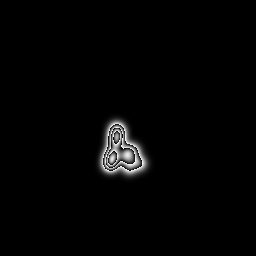

In [51]:
T.ToPILImage()(cum)

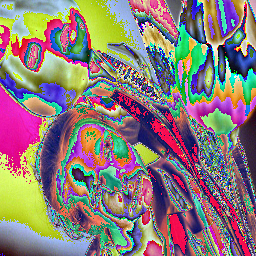

In [52]:
T.ToPILImage()(first_image["image"])

In [34]:
import cv2

In [35]:
keypoints = [cv2.KeyPoint(float(x), float(y), size=20) for (x, y) in first_image["final_keypoints"]]

In [36]:
keypoints

[< cv2.KeyPoint 0x7f555404eab0>,
 < cv2.KeyPoint 0x7f555404edb0>,
 < cv2.KeyPoint 0x7f555404e180>,
 < cv2.KeyPoint 0x7f555404ee40>,
 < cv2.KeyPoint 0x7f555404e450>,
 < cv2.KeyPoint 0x7f555404e3c0>,
 < cv2.KeyPoint 0x7f555404ec60>,
 < cv2.KeyPoint 0x7f555404e600>,
 < cv2.KeyPoint 0x7f555404ec90>,
 < cv2.KeyPoint 0x7f555404e660>,
 < cv2.KeyPoint 0x7f555404e510>,
 < cv2.KeyPoint 0x7f555404e480>,
 < cv2.KeyPoint 0x7f555404eb40>,
 < cv2.KeyPoint 0x7f555404e810>,
 < cv2.KeyPoint 0x7f555404ea50>,
 < cv2.KeyPoint 0x7f555404a5a0>,
 < cv2.KeyPoint 0x7f555404a180>,
 < cv2.KeyPoint 0x7f555404ab10>,
 < cv2.KeyPoint 0x7f555404a510>]

In [39]:
first_image["image"]

tensor([[[-0.5082, -0.5767, -0.5767,  ..., -1.1932, -1.2274, -1.2617],
         [-0.5253, -0.4911, -0.4568,  ..., -1.1932, -1.2103, -1.2274],
         [-0.4911, -0.4397, -0.3883,  ..., -1.1932, -1.1932, -1.2103],
         ...,
         [-0.7993, -0.8335, -0.7993,  ..., -1.5870, -1.7583, -1.2617],
         [-0.8164, -0.8507, -0.8164,  ..., -1.1075, -1.7069, -1.4500],
         [-0.8164, -0.8164, -0.8164,  ..., -0.2856, -1.6727, -1.4843]],

        [[-0.3901, -0.4951, -0.4776,  ..., -1.3880, -1.3704, -1.4055],
         [-0.3901, -0.4076, -0.3725,  ..., -1.3880, -1.3880, -1.4055],
         [-0.3550, -0.3200, -0.2850,  ..., -1.3880, -1.3880, -1.4055],
         ...,
         [-0.9853, -0.9678, -0.9678,  ..., -1.7731, -1.7381, -1.3354],
         [-1.0028, -0.9853, -0.9853,  ..., -1.2304, -1.7556, -1.5280],
         [-1.0028, -0.9853, -0.9853,  ..., -0.3025, -1.7731, -1.5805]],

        [[-0.5670, -0.6193, -0.6715,  ..., -1.3164, -1.2990, -1.3164],
         [-0.5495, -0.4624, -0.4101,  ..., -1

In [37]:
imageread = T.ToPILImage()(first_image["image"])

output_image = cv2.drawKeypoints(imageread, keypoints, 0, (255, 0, 0), 
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
  
# displaying the image with keypoints as the 
# output on the screen 
plt.imshow(output_image) 
  
# plotting image 
plt.show() 

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'drawKeypoints'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'


<Axes: >

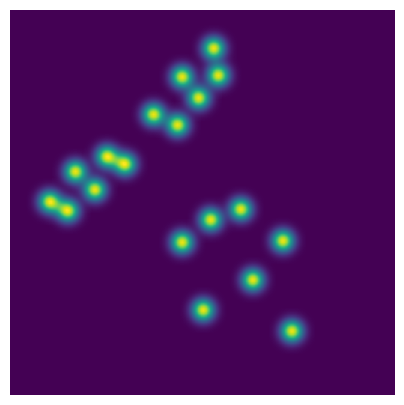

In [13]:
show_image(cum)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

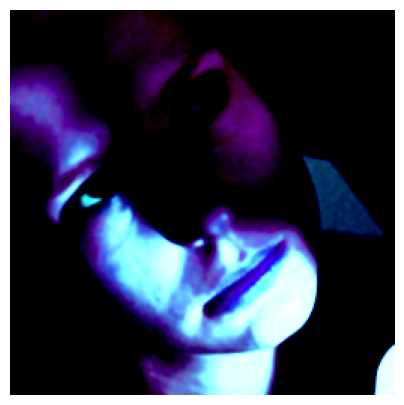

In [14]:
show_image(first_image['image'])

In [12]:
cum = None
for keypoint in first_image['label']:
    a = keypoint
    if cum is None:
        cum = a 
    else:
        cum = cum + a

In [ ]:
coords = []
for i in range(len(first_image['label'])):
    if i%2 == 0:
        coords.append((first_image['label'][i], first_image['label'][i+1]))

In [ ]:
len(coords)

In [ ]:
keypoints = [cv2.KeyPoint(float(x), float(y), size=20) for (x, y) in coords]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
first_image['image'].numpy()

In [ ]:
output_image = cv2.drawKeypoints(first_image['image'].permute(1, 2, 0).numpy(), keypoints, 0, (255, 0, 0), 
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
  
# displaying the image with keypoints as the 
# output on the screen 
plt.imshow(output_image) 
  
# plotting image 
plt.show() 